In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, \
accuracy_score, classification_report, log_loss, ConfusionMatrixDisplay, confusion_matrix, \
RocCurveDisplay, make_scorer, roc_auc_score

from pickle import dump, load

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/cleaned_df.csv', index_col = 0)
df.head()

,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,loan_status,purpose,addr_state,...,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit
0,4000,36 months,11.99,132.84,8 years,RENT,45000.0,Fully Paid,debt_consolidation,AZ,...,9,1,7,0,1,100.0,0.0,0,1102,7500
1,7200,36 months,11.47,237.33,< 1 year,RENT,85000.0,Current,debt_consolidation,OR,...,8,4,6,0,2,90.0,100.0,0,33021,14000
2,20000,36 months,16.29,706.01,8 years,MORTGAGE,56000.0,Current,debt_consolidation,FL,...,20,12,21,0,4,96.6,75.0,2,54298,9700
3,16000,60 months,12.99,363.97,5 years,MORTGAGE,110000.0,Current,debt_consolidation,IL,...,21,11,14,0,2,68.0,87.5,0,45733,39400
4,28000,60 months,15.31,670.69,3 years,MORTGAGE,180000.0,Current,debt_consolidation,TN,...,14,7,14,0,5,93.9,100.0,0,273107,51800


## Train-Test Split

In [3]:
# feature selection, target variable = 'Drafted'
X = df.drop(['loan_status'], axis = 1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state= 42)

In [4]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(309882, 44)
(103295, 44)
(309882,)
(103295,)


## Preprocessing

We'll take the df we cleaned and preprocess the categorical and numerical columns. The categorical columns will be one-hot encoded and the numerical columns will be scaled. 

In [5]:
# identify ordinal columns and define order of the features
# only ordinal column is emp_length
emp_length_list = ['< 1 year',
                   '1 year',
                   '2 years',
                   '3 years',
                   '4 years',
                   '5 years',
                   '6 years',
                   '7 years',
                   '8 years',
                   '9 years',
                   '10+ years']

In [6]:
# convert to type category
X_train['emp_length'] = X_train['emp_length'].astype('category')

In [7]:
# get all nominal columns
nominal_cols = list(X_train.select_dtypes(include='object').columns)

# get all ordinal columns
ordinal_cols = list(X_train.select_dtypes(include='category').columns)

# get all numeric columns
numeric_cols = list(X_train.select_dtypes(include= ['int', 'float']).columns)

In [8]:
# get counts of cols
print(len(nominal_cols), "Nominal Columns:", nominal_cols)
print("")
print(len(ordinal_cols), "Ordinal Columns:", ordinal_cols)
print("")
print(len(numeric_cols), "Numeric Columns:", numeric_cols)

5 Nominal Columns: ['term', 'home_ownership', 'purpose', 'addr_state', 'application_type']

1 Ordinal Columns: ['emp_length']

38 Numeric Columns: ['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'years_credit', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'open_act_il', 'open_il_24m', 'open_rv_24m', 'all_util', 'total_rev_hi_lim', 'inq_last_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'total_bal_ex_mort', 'total_bc_limit']


### Building pipeline transformer

In [9]:
# define a nominal transformation pipeline that OHE the cats
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(sparse = False))])

# define an ordinal transformation pipeline that ordinal encodes the cats
ordinal_pipeline = Pipeline([('ordinalenc', OrdinalEncoder(categories = [emp_length_list]))])

# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler())]) 

In [10]:
# construct column transformer for the selected columns with pipelines
ct = ColumnTransformer(transformers = [("nominalpipe", nominal_pipeline, nominal_cols),
                                       ("ordinalpipe", ordinal_pipeline, ordinal_cols),
                                       ("numericpipe", numeric_pipeline, numeric_cols)])

In [11]:
# save the column transformer
dump(ct, open('pkl/modeling_column_transformer.pkl', 'wb'))

In [12]:
# reorder the df with nominal first, ordinal second, and remaining numeric last
ordered_cols = nominal_cols + ordinal_cols + numeric_cols
X_train = X_train[ordered_cols]
X_test = X_test[ordered_cols]

## Transforming

In [13]:
X_train_pp = pd.DataFrame(ct.fit_transform(X_train))
X_test_pp = pd.DataFrame(ct.transform(X_test))

In [14]:
print(X_train_pp.shape)
print(X_test_pp.shape)

(309882, 112)
(103295, 112)


In [15]:
X_train_pp.head()

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.375574,3.332640,1.032006,-0.170992,1.548213,0.684748,-0.152562,-0.375143,-0.244984,-0.056132
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-1.085858,-0.749310,-1.162842,-0.170992,-0.597757,0.684748,-1.157716,2.168118,-0.832390,0.103450
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.155856,0.192679,1.214910,-0.170992,-0.597757,0.684748,0.684146,-0.375143,0.019934,-0.847103
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.554428,-0.121318,-0.065418,-0.170992,-0.597757,-1.916451,-0.238166,-0.375143,-0.604350,-0.319789
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.109859,-1.377302,-0.431226,-0.170992,-1.134250,0.289365,-1.157716,-0.375143,-0.594479,1.109510


### Get Feature Names and Assign to `X_train_pp`

In [16]:
# get nominal values
nominal_features = list(nominal_pipeline.named_steps['onehotenc'].fit(df[nominal_cols]).get_feature_names_out())

In [17]:
# get nominal values
ordinal_features = list(nominal_pipeline.named_steps['onehotenc'].fit(df[ordinal_cols]).get_feature_names_out())

In [18]:
print(len(nominal_features), "Nominal Encoded Feature Names:", nominal_features[0:5], "...")
print("")
print(len(ordinal_features), "Ordinal Encoded Feature Names:", ordinal_features[0:5], "...")
print("")
print(len(numeric_cols), "Numeric Features", numeric_cols[0:5], "...")

73 Nominal Encoded Feature Names: ['term_ 36 months', 'term_ 60 months', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE'] ...

11 Ordinal Encoded Feature Names: ['emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years'] ...

38 Numeric Features ['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti'] ...


In [19]:
# redefine the column names
X_train_pp.columns = nominal_features + ordinal_cols + numeric_cols

# redefine the column names
X_test_pp.columns = nominal_features + ordinal_cols + numeric_cols

In [20]:
X_train_pp.head()

,term_ 36 months,term_ 60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,...,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.375574,3.332640,1.032006,-0.170992,1.548213,0.684748,-0.152562,-0.375143,-0.244984,-0.056132
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-1.085858,-0.749310,-1.162842,-0.170992,-0.597757,0.684748,-1.157716,2.168118,-0.832390,0.103450
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.155856,0.192679,1.214910,-0.170992,-0.597757,0.684748,0.684146,-0.375143,0.019934,-0.847103
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.554428,-0.121318,-0.065418,-0.170992,-0.597757,-1.916451,-0.238166,-0.375143,-0.604350,-0.319789
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.109859,-1.377302,-0.431226,-0.170992,-1.134250,0.289365,-1.157716,-0.375143,-0.594479,1.109510


## Modeling

I'll now build a few models to classify the different loan statuses. Since this is a multi-class classification with 6 classes, I'll use the F1-Score to measure the performance of the model. Ideally, we want a high F1-Score which finds a harmonic ballance between precision and recall. 

### Baseline

In [21]:
# build baseline log reg pipeline 
steps = [('preprocess', ct), 
         ('model', LogisticRegression(random_state = 42))]

lr_pipeline = Pipeline(steps)

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['term', 'home_ownership',
                                                   'purpose', 'addr_state',
                                                   'application_type']),
                                                 ('ordinalpipe',
                                                  Pipeline(steps=[('ordinalenc',
                                                                   OrdinalEncoder(categories=[['< '
                                                                                               '1 '
                                                                                               'year',
                                                                                               '1 '
                                                                                               'year',
                                                                                               '2 '
                                                                                               'years',
                                                                                               '3 '
                                                                                               'years',
                                                                                               '4 '
                                                                                               'ye...
                                                   'revol_util', 'total_acc',
                                                   'open_act_il', 'open_il_24m',
                                                   'open_rv_24m', 'all_util',
                                                   'total_rev_hi_lim',
                                                   'inq_last_12m',
                                                   'acc_open_past_24mths',
                                                   'bc_open_to_buy', 'bc_util',
                                                   'mort_acc',
                                                   'mths_since_recent_bc',
                                                   'mths_since_recent_bc_dlq',
                                                   'mths_since_recent_revol_delinq',
                                                   'num_accts_ever_120_pd',
                                                   'num_rev_accts',
                                                   'num_rev_tl_bal_gt_0', ...])])),
                ('model', LogisticRegression(random_state=42))])

In [22]:
# helper function to get AUC score
def get_auc(model, X, y):
    # get y_prob
    y_prob = model.predict_proba(X)
    score = roc_auc_score(y, y_prob, multi_class = 'ovr')
    return round(score,3)

In [23]:
# create a tracking list of f1 and AUC scores
f1_train_list = []
f1_test_list = []
auc_list = []

Baseline - Logistic Regression F1 Score (Training): 0.4939
Baseline - Logistic Regression F1 Score (Test): 0.4928
AUC Test Score: 0.656
--------------------------------------------------------------------------------
                    precision    recall  f1-score   support

       Charged Off       0.34      0.04      0.07      9871
           Current       0.60      0.93      0.73     58869
        Fully Paid       0.49      0.16      0.24     31052
   In Grace Period       0.00      0.00      0.00       974
 Late (16-30 days)       0.00      0.00      0.00       545
Late (31-120 days)       0.00      0.00      0.00      1984

          accuracy                           0.58    103295
         macro avg       0.24      0.19      0.17    103295
      weighted avg       0.52      0.58      0.49    103295



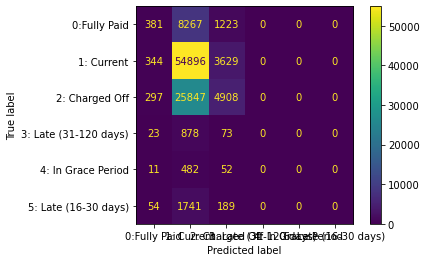

In [24]:
# define class_names for confusion matrix label moving forward
class_names = ['0:Fully Paid', '1: Current', '2: Charged Off', '3: Late (31-120 days)',
       '4: In Grace Period', '5: Late (16-30 days)']

# plot matrix on testing set
predictions = lr_pipeline.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=lr_pipeline.classes_)

cm_display = ConfusionMatrixDisplay(cm,
                                    display_labels = class_names)

# get f1 scores and AUC
f1_train1 = round(f1_score(y_train, lr_pipeline.predict(X_train), average = 'weighted'),4)
f1_test1 = round(f1_score(y_test, lr_pipeline.predict(X_test), average = 'weighted'), 4)
auc1 = get_auc(lr_pipeline, X_test, y_test)

# append to scores list
f1_train_list.append(f1_train1)
f1_test_list.append(f1_test1)
auc_list.append(auc1)

print('Baseline - Logistic Regression F1 Score (Training):', f1_train1)
print('Baseline - Logistic Regression F1 Score (Test):', f1_test1)
print('AUC Test Score:', auc1)
print('-'*80)

# get classification report on the test set
y_pred = lr_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# plot confusion matrix
cm_display.plot()
plt.show()

## Decision Tree Classifier

In [25]:
# build new DCT pipeline 
steps = [('preprocess', ct), 
         ('dtc', DecisionTreeClassifier (random_state = 42))]

dtc = Pipeline(steps)

dtc.fit(X_train,y_train)

# define new parameters in the grid
dtc_pipe_grid = {'dtc__criterion': ['entropy'],
                'dtc__max_depth': [5],  
                'dtc__min_samples_split': [5],
                'dtc__min_samples_leaf': [5]}  

# grid search with default accuracy scoring, because error with f1 scoring
dtc = GridSearchCV(estimator = dtc, 
                             param_grid = dtc_pipe_grid) 

# run this to find best parameters based on gridsearch 
dtc.fit(X_train, y_train)

# get best scores and parameters
display(dtc.best_params_)
display(dtc.best_score_)

{'dtc__criterion': 'entropy',
 'dtc__max_depth': 5,
 'dtc__min_samples_leaf': 5,
 'dtc__min_samples_split': 5}

nan

DTC F1 Score (Training): 0.4576
DTC F1 Score (Test): 0.4567
AUC Test Score: 0.621
--------------------------------------------------------------------------------
                    precision    recall  f1-score   support

       Charged Off       0.00      0.00      0.00      9871
           Current       0.58      0.96      0.72     58869
        Fully Paid       0.44      0.09      0.15     31052
   In Grace Period       0.00      0.00      0.00       974
 Late (16-30 days)       0.00      0.00      0.00       545
Late (31-120 days)       0.00      0.00      0.00      1984

          accuracy                           0.57    103295
         macro avg       0.17      0.17      0.15    103295
      weighted avg       0.46      0.57      0.46    103295



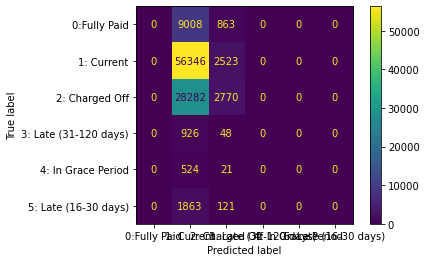

In [26]:
# plot matrix on testing set
predictions = dtc.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels= dtc.classes_)

cm_display = ConfusionMatrixDisplay(cm,
                                    display_labels = class_names)

# get f1 scores and AUC
f1_train1 = round(f1_score(y_train, dtc.predict(X_train), average = 'weighted'),4)
f1_test1 = round(f1_score(y_test, dtc.predict(X_test), average = 'weighted'), 4)
auc1 = get_auc(dtc, X_test, y_test)

# append to scores list
f1_train_list.append(f1_train1)
f1_test_list.append(f1_test1)
auc_list.append(auc1)

print('DTC F1 Score (Training):', f1_train1)
print('DTC F1 Score (Test):', f1_test1)
print('AUC Test Score:', auc1)
print('-'*80)

# get classification report on the test set
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))

# plot confusion matrix
cm_display.plot()
plt.show()

## XGBoost Classifier

In [28]:
# encode y classes for xgb
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [51]:
# Instantiate an XGB Classifier
steps = [('preprocess', ct),
         ('xgb', XGBClassifier(random_state = 42))]

xgb = Pipeline(steps)

xgb.fit(X_train, le.fit_transform(y_train))

param_grid = {
    'xgb__learning_rate': [0.01],
    'xgb__max_depth': [2],
    'xgb__n_estimators': [100]
} 

# find best param based on f1 score
xgb = GridSearchCV(estimator = xgb, 
                       param_grid = param_grid,
                       scoring = 'f1') # goes through all parameters in the defined grid

# run this to find best parameters based on gridsearch 
xgb.fit(X_train, le.fit_transform(y_train))

# get best scores and parameters
display(xgb.best_params_)
display(xgb.best_score_)

{'xgb__learning_rate': 0.01, 'xgb__max_depth': 2, 'xgb__n_estimators': 100}

nan

In [52]:
# build pipeline 
steps = [('preprocess', ct),
         ('xgb', XGBClassifier(random_state = 42))]

xgb = Pipeline(steps)
xgb.fit(X_train,  le.fit_transform(y_train))


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['term', 'home_ownership',
                                                   'purpose', 'addr_state',
                                                   'application_type']),
                                                 ('ordinalpipe',
                                                  Pipeline(steps=[('ordinalenc',
                                                                   OrdinalEncoder(categories=[['< '
                                                                                               '1 '
                                                                                               'year',
                                                                                               '1 '
                                                                                               'year',
                                                                                               '2 '
                                                                                               'years',
                                                                                               '3 '
                                                                                               'years',
                                                                                               '4 '
                                                                                               'ye...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

XGB F1 Score (Training): 0.5814
XGB F1 Score (Test): 0.5418
AUC Test Score: 0.667
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.39      0.06      0.11      9871
           1       0.63      0.89      0.74     58869
           2       0.51      0.29      0.37     31052
           3       0.00      0.00      0.00       974
           4       0.00      0.00      0.00       545
           5       0.00      0.00      0.00      1984

    accuracy                           0.60    103295
   macro avg       0.25      0.21      0.20    103295
weighted avg       0.55      0.60      0.54    103295



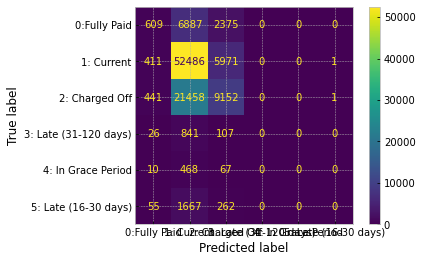

In [53]:
# plot matrix on testing set
predictions = xgb.predict(X_test)
cm = confusion_matrix(le.transform(y_test), predictions, labels= xgb.classes_)

cm_display = ConfusionMatrixDisplay(cm,
                                    display_labels = class_names)

# get f1 scores and AUC
f1_train1 = round(f1_score( le.fit_transform(y_train), xgb.predict(X_train), average = 'weighted'),4)
f1_test1 = round(f1_score(le.fit_transform(y_test), xgb.predict(X_test), average = 'weighted'), 4)
auc1 = get_auc(xgb, X_test, y_test)

# append to scores list
f1_train_list.append(f1_train1)
f1_test_list.append(f1_test1)
auc_list.append(auc1)

print('XGB F1 Score (Training):', f1_train1)
print('XGB F1 Score (Test):', f1_test1)
print('AUC Test Score:', auc1)
print('-'*80)

# get classification report on the test set
y_pred = xgb.predict(X_test)
print(classification_report(le.fit_transform(y_test), y_pred))

# plot confusion matrix
cm_display.plot()
plt.show()

## Feature Importance

Evaluating the model's feature importances will assist in understanding how the model makes predictions. While the performance leaves much to be desired, we can stil, identify the features that provide the greatest impact. This will at least inform us how the model classified "Current" loans vs all other loan statuses. 

In [54]:
# set best model
best_model = xgb

In [55]:
# check feature importances 
feat_imp = best_model['xgb'].feature_importances_  

feat_imp_series = pd.Series(feat_imp, 
          index = X_train_pp.columns)

# preview first 5
feat_imp_series[:5]

term_ 36 months            0.086146
term_ 60 months            0.000000
home_ownership_ANY         0.009335
home_ownership_MORTGAGE    0.012783
home_ownership_NONE        0.000000
dtype: float32

In [56]:
top_15_features= pd.DataFrame(feat_imp_series.sort_values(ascending = False).head(15)).reset_index()
top_15_features = top_15_features.rename(columns = {'index': 'Feature', 0: 'Importance'})
top_15_features

,Feature,Importance
0,term_ 36 months,0.086146
1,int_rate,0.043425
2,acc_open_past_24mths,0.035134
3,application_type_Individual,0.031096
4,mort_acc,0.025016
5,addr_state_CA,0.019796
6,addr_state_CO,0.017757
7,open_il_24m,0.017710
8,addr_state_IL,0.015551
9,addr_state_UT,0.015370


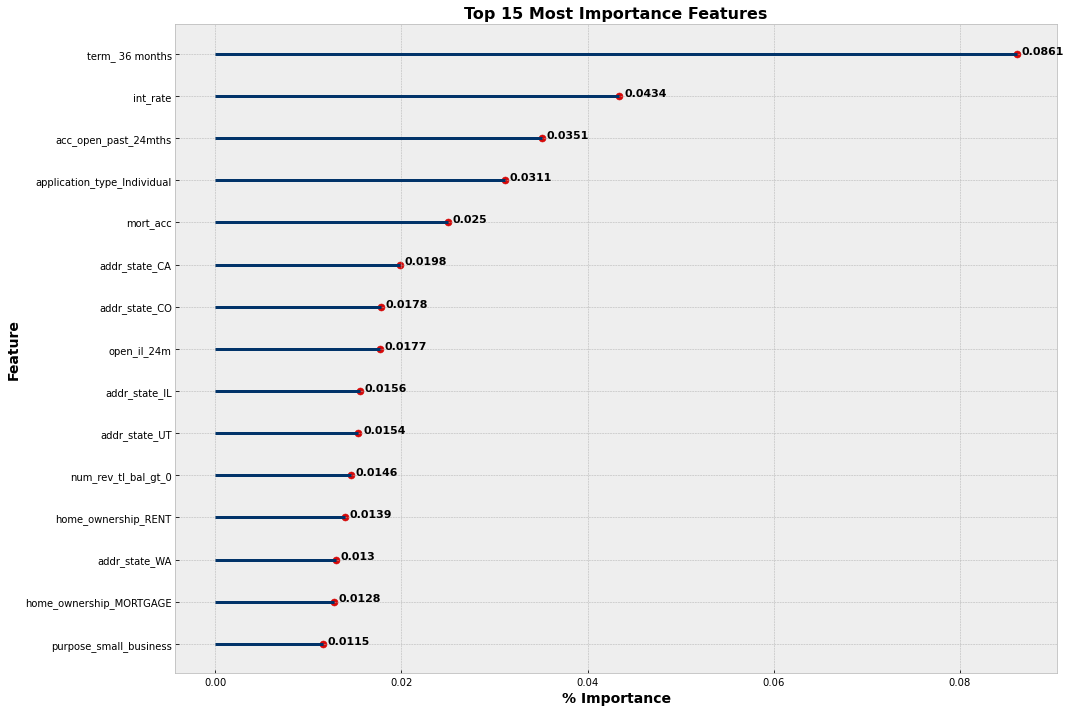

In [57]:
# plot a lollipop plot of top 15 most important features
fig, ax = plt.subplots(figsize=(15, 10))
plt.style.use('bmh')

# sort by descending
top_15_features= top_15_features.sort_values(by = 'Importance')

# plots the lines
plt.hlines(y = top_15_features['Feature'],  # feature
           xmin = 0,
           xmax = top_15_features['Importance'],  # importance
           color = '#013369', linewidth = 3)

plt.scatter(top_15_features['Importance'], # Count values
            top_15_features['Feature'],  # positions
            color='#d50a0a', 
            alpha=1, s = 50)

# annotate the scatter plot values
for idx, row in top_15_features.iterrows():
    ax.annotate(round(row['Importance'],4), (row['Importance'], row['Feature'] ), 
                weight = "bold", fontsize = 11, 
                xytext=(row['Importance'] + 0.0005, row['Feature'])) # offset annotate

plt.title('Top 15 Most Importance Features', weight = "bold", fontsize = 16)
plt.ylabel('Feature', weight = "bold", fontsize = 14)
plt.xlabel('% Importance', weight = "bold", fontsize = 14)

plt.tight_layout()
plt.show()

## Evaluation & Additional Steps

While the model struggled to make correct classification amongst the different loans, there are at least a few takeaways during this exercise that can be explored further. In the interest of time, I have outlined a few actions that could be explored further. 

**Feature Importances & Recommendation for Investment**
- The most popular loan type of 36 months and loans with higher interest rates appear to be the greatest influencers in identifying loan statuses. This makes sense, as an investor, I would want to invest in loans with greater interest rates and hope to yield a greater return in a shorter amount of time. Individual borrowers who have recently opened accounts also tend to be a good indicator as well. These features appear to have the greatest factor in classifying Current loans and would be the type of accounts I would target for investment. 

**Class Imbalance**
- A evidenced by the distribution of the loan statuses, there is a class imbalance amongst the 6 classes. Ideally, we'd want to this as the majority class creates a bias. This could be fixed by either under-sampling the majority class or over-sampling the remainder minority classes. 

**Simplifying the Dataset**
- In additional to a relatively large dataset, there are many features to model. Generally, we'd like to simplify the model to reduce computing time and perform some feature selection exercises such as PCA. 


